In [1]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
import torchvision
import torch.nn as nn
from torch import optim
from sklearn.metrics import classification_report
from torchvision import models
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image,preprocess_image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
def get_data(path , type ="train"):
    
    directories = os.listdir(path)

    images = []
    targets = []
    class_map = {}
    for idx , x in enumerate(directories):
            if type == "train":
                class_map[x] = idx
            image_list = os.listdir(path + '/' + x)
            images += [path + '/' + x + '/' + each_image for each_image in image_list]
            targets += [idx for _ in  image_list]
    if type == "test":
         return images , targets
        
    return images , targets , class_map

In [38]:
class_map

{'right': 0, 'left': 1, 'down': 2, 'up': 3}

In [6]:
train_path = os.getcwd() + '/Directions01/train'
test_path = os.getcwd() + '/Directions01/test'

In [7]:


train_images , train_targets , class_map = get_data(train_path)
test_images , test_targets = get_data(test_path , "test")

In [8]:
transform =  transforms.Compose([transforms.Resize((224,224)) , transforms.Grayscale(num_output_channels=3), transforms.ToTensor() , transforms.RandomAdjustSharpness(1.2) ])

In [9]:
def read_image_file(path)-> torch.Tensor:
        image_locations_tensor = []
        
        for index , rows in path.iterrows():
            img = Image.open(rows.values[0])
            image_locations_tensor += [transform(img)]
            
        return torch.stack(image_locations_tensor)
        
def read_label_file(target)-> torch.Tensor:
        labels = target[0]
        labels_tensor = torch.tensor(labels)
        return labels_tensor

In [10]:
class InputData(Dataset):
    def __init__(self, path , target , transform  = None):
        self.path  = path
        self.targets_columns = target
        self.transform = transform
        self.data , self.targets = self._load_data(self.path , self.targets_columns)

    
    def _load_data(self , path , target):
        image_file = path
        data = read_image_file(path)

        label_file = target
        targets = read_label_file(target)
        
        return data , targets
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.path.iloc[idx,0]
        img = Image.open(image)
        
        if self.transform:
            data = self.transform(img)
        
        target = int(self.targets_columns.iloc[idx,0])
            
        return (data , target)

In [11]:
train_data  = InputData(pd.DataFrame(train_images) , pd.DataFrame(train_targets) , transform)
test_data  = InputData(pd.DataFrame(test_images) , pd.DataFrame(test_targets) , transform)

In [12]:
train_data.data.shape

torch.Size([948, 3, 224, 224])

In [13]:
test_data.targets.shape

torch.Size([40])

In [14]:
train_data_loader = torch.utils.data.DataLoader(train_data , batch_size = 24 , shuffle = True , num_workers = 2)
test_data_loader = torch.utils.data.DataLoader(test_data , batch_size = 24 , shuffle = True , num_workers = 2)

In [15]:
def train(net , train_data_loader , criterion , optimizer , num_epochs = 3):
    
    net.train()
    for iteration in range(num_epochs):
        for i , data in enumerate(train_data_loader):
            
            inp_data , labels = data
            inp_data , labels = inp_data.to(device) , labels.to(device)
     
            outputs = net(inp_data)
            loss_val = criterion(outputs , labels)

            optimizer.zero_grad()

            loss_val.backward()

            optimizer.step()

            if (i + 1) % 2 == 0:
                print(f" Epoch = [{iteration + 1} / {num_epochs}] Step = [{i + 1} / {len(train_data_loader)}] Loss = {loss_val.item()} ")

In [16]:
def test(net ,test_data_loader , criterion):
    correct = 0 
    total = 0
    test_loss = 0
    y_pred = []
    y_true = []
    
    net.eval()
    
    with torch.no_grad():
        for data in test_data_loader:
            inp_data , labels = data
            inp_data , labels = inp_data.to(device) , labels.to(device)
            
            outputs  = net(inp_data)
            
            loss_val = criterion(outputs , labels)
            
            test_loss += loss_val.item()
            
            pred_y = torch.max(outputs , 1)[1].data.squeeze()
            total += labels.size(0)
            
            y_pred += pred_y.cpu().tolist()
            y_true += labels.cpu().tolist()
            
            correct += (pred_y == labels).sum().item()
            
    accuracy = correct / total
    print(f"Test Accuracy of the model is : {accuracy * 100 : .2f} %")
    print(f"Overall test loss of the model is : {test_loss} ")
    return y_true, y_pred
    

In [17]:
resnet = torchvision.models.resnet18(weights = 'DEFAULT')
# resnet.conv1 =  torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters() , lr = 0.01)

train(resnet.to(device) , train_data_loader , criterion , optimizer)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s] 


 Epoch = [1 / 3] Step = [2 / 40] Loss = 1.0866093635559082 
 Epoch = [1 / 3] Step = [4 / 40] Loss = 2.721209764480591 
 Epoch = [1 / 3] Step = [6 / 40] Loss = 0.8743545413017273 
 Epoch = [1 / 3] Step = [8 / 40] Loss = 0.38615819811820984 
 Epoch = [1 / 3] Step = [10 / 40] Loss = 0.35994622111320496 
 Epoch = [1 / 3] Step = [12 / 40] Loss = 0.2910078763961792 
 Epoch = [1 / 3] Step = [14 / 40] Loss = 0.47758665680885315 
 Epoch = [1 / 3] Step = [16 / 40] Loss = 0.40555539727211 
 Epoch = [1 / 3] Step = [18 / 40] Loss = 0.09663518518209457 
 Epoch = [1 / 3] Step = [20 / 40] Loss = 0.168193519115448 
 Epoch = [1 / 3] Step = [22 / 40] Loss = 0.0287571232765913 
 Epoch = [1 / 3] Step = [24 / 40] Loss = 0.041281770914793015 
 Epoch = [1 / 3] Step = [26 / 40] Loss = 0.11248526722192764 
 Epoch = [1 / 3] Step = [28 / 40] Loss = 0.008393017575144768 
 Epoch = [1 / 3] Step = [30 / 40] Loss = 0.46909746527671814 
 Epoch = [1 / 3] Step = [32 / 40] Loss = 0.001414174330420792 
 Epoch = [1 / 3] Ste

In [18]:
y_true, y_pred = test(resnet.to(device) , test_data_loader , criterion )

Test Accuracy of the model is :  90.00 %
Overall test loss of the model is : 1.189921036362648 


In [19]:
print(classification_report(y_true , y_pred , labels = range(0, 4)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       1.00      0.80      0.89        10
           2       0.77      1.00      0.87        10
           3       1.00      0.90      0.95        10

    accuracy                           0.90        40
   macro avg       0.92      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40



In [20]:
y_true, y_pred = test(resnet.to(device) , train_data_loader , criterion )

Test Accuracy of the model is :  90.19 %
Overall test loss of the model is : 18.007768859155476 


In [21]:
print(classification_report(y_true , y_pred , labels = range(0, 4)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       237
           1       1.00      0.67      0.80       237
           2       0.80      1.00      0.89       237
           3       0.90      0.99      0.94       237

    accuracy                           0.90       948
   macro avg       0.92      0.90      0.90       948
weighted avg       0.92      0.90      0.90       948



In [23]:
! pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=93f43e4835f484df1a3baf107ec5d36849a0652802592aa103f94c73439307ab
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


torch.Size([1, 3, 224, 224])
[BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)]


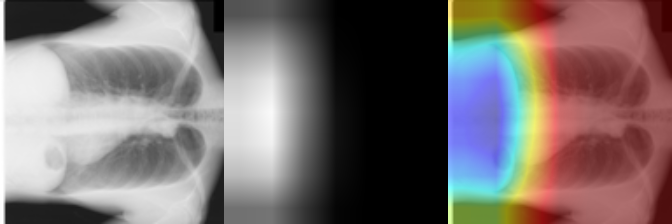

In [54]:
resnet.eval()
image_url = os.getcwd() + "/Directions01/test/right/1.png"
img = np.array(Image.open(image_url))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
img = cv2.merge([img , img , img])
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

target_layers = [resnet.layer4[-1]]
targets = [ClassifierOutputTarget(0)]

with GradCAM(model=resnet, target_layers=target_layers , use_cuda= True) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets , aug_smooth=True)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :])

cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

# 